In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Look at columns in the measurement table:
inspector = inspect(engine)
columns = inspector.get_columns("measurement")
for column in columns:
    print(column["name"], column["type"])



# Calculate the date 1 year ago from the last data point in the database
# First find the last date:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


('2017-08-23')

In [10]:
# Calculate the date 1 year ago from the last data point in the database

year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [11]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

precip_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).\
                            order_by(Measurement.date).all()

precip_data = pd.DataFrame(precip_query)
precip_data.head()
precip_data = precip_data.set_index("date")
precip_data.head()


,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [12]:
len(precip_data)

2230

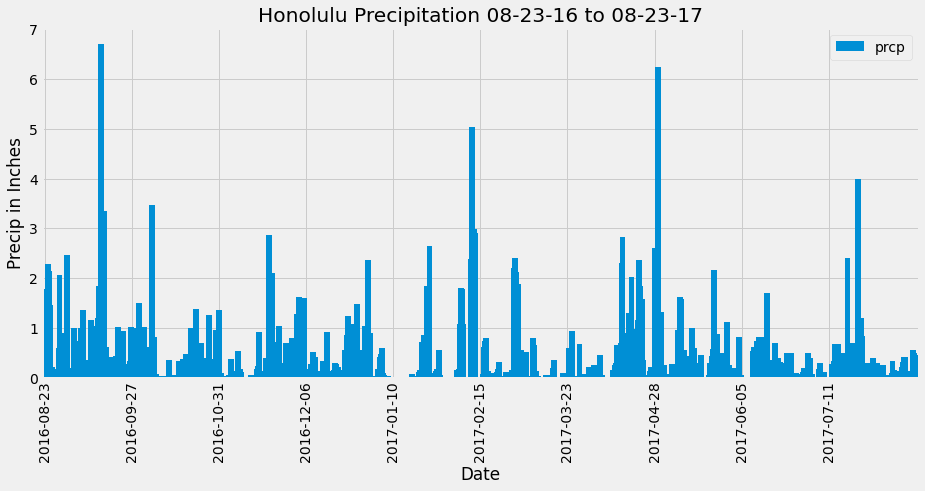

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data:

tick_locations = list(range(0, 2230, 223))
tick_labels = []
                                        
for x in tick_locations:
    date = precip_data.index[x]   
    tick_labels.append(date)

precip_data.plot.bar(figsize=(14, 6), width=15)
plt.xticks(tick_locations, tick_labels, rotation="vertical")
plt.title("Honolulu Precipitation 08-23-16 to 08-23-17")
plt.ylabel("Precip in Inches")
plt.xlabel("Date")
#plt.xticks([])
 
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_data.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Look at columns in the station table:

inspector2 = inspect(engine)
columns = inspector2.get_columns("station")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Design a query to show how many stations are available in this dataset:

stations = []
for value in session.query(Station.station):
    stations.append(value)
print(f" There are {len(stations)} stations.")

 There are 9 stations.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_count = pd.DataFrame(engine.execute(f"SELECT station, COUNT(prcp) FROM measurement GROUP BY station \
                                            ORDER BY COUNT(station) DESC;"))
station_count = station_count.rename(columns = {0:"Station", 1:"Measurement Count"})
station_count


,Station,Measurement Count
0,USC00519281,2772
1,USC00519397,2685
2,USC00513117,2696
3,USC00519523,2572
4,USC00516128,2484
5,USC00514830,1937
6,USC00511918,1932
7,USC00517948,683
8,USC00518838,342


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# (Day 3 Activity 1 for 'sel')
    
most_active = station_count["Station"].iloc[0]
most_active


'USC00519281'

In [19]:
# Query for the results and save to a dataframe:
sel = f"SELECT station, MIN(tobs), MAX(tobs), AVG(tobs) FROM measurement WHERE station = '{most_active}'"
most_active_stats = pd.DataFrame(engine.execute(sel).fetchall())
most_active_stats = most_active_stats.rename(columns={0:'Station ID', 1:'Min Temp', 2:'Max Temp', 3:'Avg Temp'})
most_active_stats

,Station ID,Min Temp,Max Temp,Avg Temp
0,USC00519281,54.0,85.0,71.663781


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and 
# plot the results as a histogram with bins=12

most_temps = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > year_ago).\
    filter(Measurement.station == most_active).\
    order_by(Measurement.date).all()

temps_df = pd.DataFrame(most_temps)
temps_df = temps_df.rename(columns={'date':"Date", 'tobs':"Temperature"})
temps_df

,Date,Temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


(0.0, 70.0)

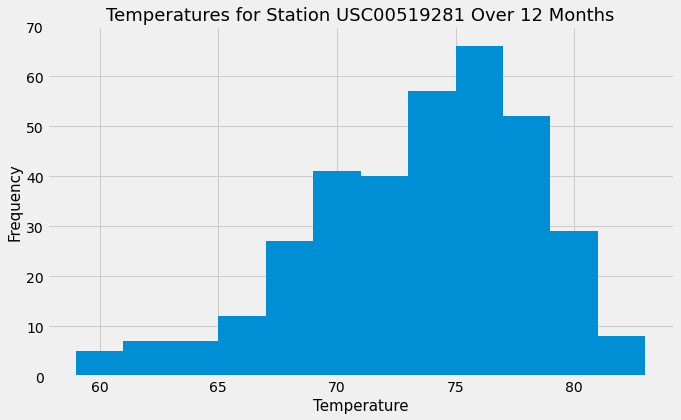

In [21]:
# Plot the results as a histogram with bins=12:

temps_df.hist(column='Temperature', figsize=[10,6], bins=12)
plt.title('Temperatures for Station USC00519281 Over 12 Months', size=18)
plt.xlabel('Temperature', size = 15)
plt.ylabel('Frequency', size = 15)
plt.ylim(0, 70)

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps('2016-05-30', '2016-06-05')
#print(trip_results)
trip_df = pd.DataFrame(trip_results, columns = ['tmin', 'tavg', 'tmax'])
trip_df

,tmin,tavg,tmax
0,64.0,71.428571,78.0


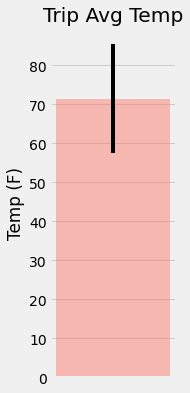

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig = plt.figure(figsize=(2, 6))
ax = fig.add_subplot()
peak_to_peak = trip_df['tmax'] - trip_df['tmin']
ax.bar(0, trip_df['tavg'], yerr=peak_to_peak, color = 'salmon', alpha=0.5)

# Formatting
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xticks([])
plt.grid(True)

plt.show()


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = f"SELECT m.station, s.name, s.latitude, s.longitude, s.elevation, SUM(m.prcp) \
        FROM measurement AS m \
        JOIN station AS s ON s.station = m.station \
        WHERE m.date BETWEEN '2016-05-30'AND '2016-06-05' \
        GROUP BY m.station \
        ORDER BY SUM(m.prcp) DESC;"
trip_rain_df = pd.DataFrame(engine.execute(sel).fetchall())
#trip_rain_df
trip_rain_df = trip_rain_df.rename(columns={0:"Station ID", 1:"Name", 2:"Latitude", 3:"Longitude", 4:"Elevation", 5:"Total Rain"})
trip_rain_df


,Station ID,Name,Latitude,Longitude,Elevation,Total Rain
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.04
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.98
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.27
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.04
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.01
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.27
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
